In [13]:
import pandas as pd
import numpy as np
import os, glob
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pickle
import json
from tqdm import tqdm

In [32]:
def process_txt_file(file_path):
    # Load the data from the file
    df = pd.read_csv(file_path, delimiter=r'\s+', skiprows=1, names=[
        "STA", "DT", "C1", "C2", "IDX", "QUAL", "RES_MS", "WT", "OFFS"
    ], engine='python')
    
    # Convert data types where appropriate
    df['DT'] = df['DT'].astype(float)
    df['C1'] = df['C1'].astype(int)
    df['C2'] = df['C2'].astype(int)
    df['IDX'] = df['IDX'].astype(int)
    df['QUAL'] = df['QUAL'].astype(float)
    df['RES_MS'] = df['RES_MS'].astype(float) / 1000  # Convert ms to s
    df['WT'] = df['WT'].astype(float)
    df['OFFS'] = df['OFFS'].astype(float)
    
    return df

def nll2df(file_path):
    extracted_data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) > 5 and parts[0].startswith("RD"):  # Phase ID starts with RD
                phase_id = parts[0]
                hrmn = parts[6]  # HrMn column
                sec = parts[7]   # Sec column
                res = parts[17]  # Res column
                extracted_data.append([phase_id, hrmn, sec, res])
    
    df_phase = pd.DataFrame(extracted_data, columns=["STA", "HrMn", "Sec", "RES_S"])
    df_phase['Sec'] = df_phase['Sec'].astype(float)
    df_phase['RES_S'] = df_phase['RES_S'].astype(float)
    #df_phase['RES_S'] = df_phase['RES_MS'] / 1000  # Convert ms to s
    
    return df_phase

def process_multiple_files(folder_path):
    file_list = glob.glob(f"{folder_path}/*202*.grid0.loc.hyp")
    merged_df = pd.DataFrame()
    
    for file in file_list:
        df = nll2df(file)
        merged_df = pd.concat([merged_df, df], ignore_index=True)
    
    return merged_df

In [37]:
df_res = process_multiple_files("D://SERD/NonLinLoc/SERD_WORKDIR/loc/")
df_res.to_csv("res_nll.csv",index=False)
df_res

,STA,HrMn,Sec,RES_S
0,RD05,20241101,1456.0,-0.0038
1,RD05,20241101,1456.0,0.0313
2,RD06,20241101,1456.0,0.0022
3,RD06,20241101,1456.0,-0.0018
4,RD01,20241101,1456.0,-0.0056
...,...,...,...,...
825,RD10,20241208,1856.0,-0.0660
826,RD14,20241208,1856.0,-0.0158
827,RD14,20241208,1856.0,-0.0107
828,RD13,20241208,1856.0,-0.2561


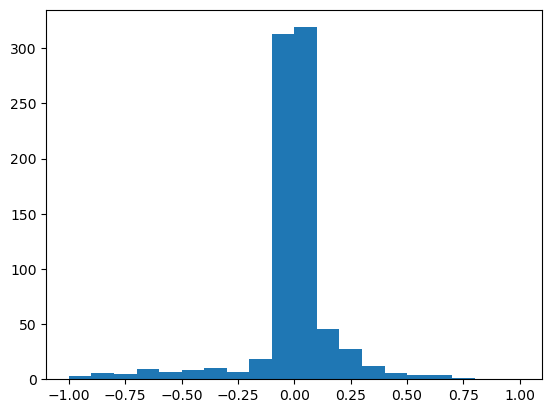

In [34]:
bin = np.arange(-1,1.1,0.1)
plt.hist(df_res['RES_S'],bins=bin)
plt.show()

# Viz Residual

In [39]:
df_wcc = pd.read_csv("res_wcc.csv")
df_nll = pd.read_csv("res_nll.csv")

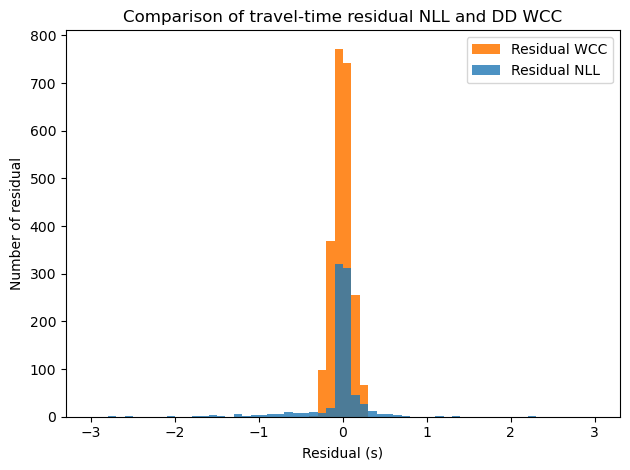

In [65]:
bin = np.arange(-3, 3.1, 0.1)

plt.hist(df_wcc['RES_S'], alpha=0.9, linewidth=1.2, label="Residual WCC", bins=bin, color='tab:orange')
plt.hist(df_nll['RES_S'], alpha=0.8, linewidth=1.2, label="Residual NLL", bins=bin, color='tab:blue')

plt.title("Comparison of travel-time residual NLL and DD WCC")
plt.ylabel("Number of residual")
plt.xlabel("Residual (s)")
plt.legend()
plt.tight_layout()
plt.savefig("residual.png",dpi=500)
plt.show()